# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [1]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
1+1
print('This is a change.')

This is a change.


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [2]:
# TODO - your code here
# Use what we did live in lecture as an example
# pandas
# matplotlib
# numpy
# seaborn
# scikit-learn


# So I'm going to read some data from UCI's machine learning repository,
# specifically, I'm going to take their AutoMPG Data Set and represt it using the seaborn visualizaiton library


import pandas as pd
import numpy as np

auto_mpg_headers = [
    "mpg",
    "cylinders", 
    "displacement",
    'horsepower',
    'weight',
    'acceleration',
    'model year',
    'origin',
    'car names'
]

# This actually took quite a while to figure out how to parse the data into this table
auto_mpg_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', sep = '\s+', header=None, names = auto_mpg_headers)
auto_mpg_df.head()

# auto_mpg_df.dtypes


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car names
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [3]:
# check for Nans 
auto_mpg_df.replace('?', np.nan, inplace = True)
auto_mpg_df.isna().values.any()
auto_mpg_df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car names       0
dtype: int64

In [4]:
# also I'm going to change the horsepower datatype to a int
print(auto_mpg_df.shape)
auto_mpg_df.dropna(inplace = True)
print(auto_mpg_df.isna().sum())
print(auto_mpg_df.shape)

(398, 9)
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car names       0
dtype: int64
(392, 9)


In [0]:
auto_mpg_df["horsepower"] = auto_mpg_df.horsepower.astype(float)

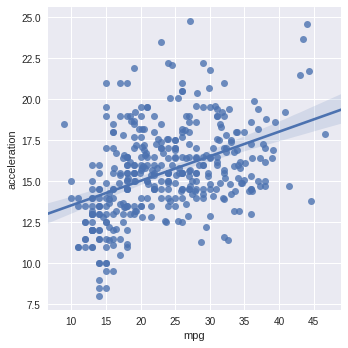

In [6]:
# Since we don't have nans, I'm going to plot MPG vs acceleration

from matplotlib import pyplot as plt
import seaborn as sns

sns.lmplot(x='mpg', y='acceleration', data=auto_mpg_df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


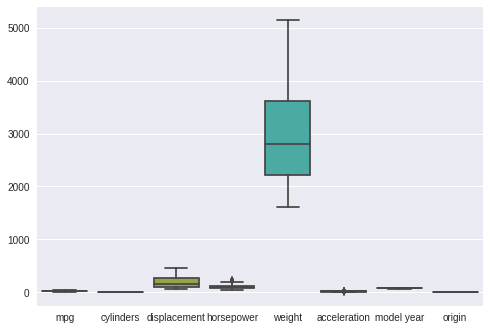

In [7]:
# So that's a big cloud of data, not clear what the important so I'll try making a 
# boxplot to get more information about the columns I've got

sns.boxplot(data=auto_mpg_df)

Since origin, model year and cylinders seem quite flat, I'll drop them and try again

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


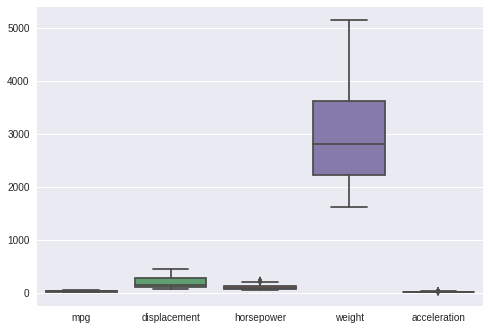

In [8]:
# pre-format DF
box_plt_df=auto_mpg_df.drop(['cylinders','model year','origin'], axis=1)

# New boxplot using the trimmed dataframe
sns.boxplot(data=box_plt_df)


Displacement and weight seem to have the most variation so I think these variables could be important feature variables if I want to predict MPG based on the cars specifications.

I'm going to try to create a predictive model and I'll be sure to include those variables.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# set features features and target

features = ['displacement', 'weight', 'acceleration']
target = 'mpg'


train, test = train_test_split(auto_mpg_df.copy(), random_state=0)
train.shape, test.shape

# train model
model = LinearRegression()
model.fit(train[features], train[target])

# train.shape, test.shape

model.score(train[features], train[target])

0.7148380175932532

So the model predicts 70% of the variability of the MPG function. But using MSE I can check the test data against the training data.

In [10]:
y_predict = model.predict(test[features])

regression_model_mse = mse(y_predict, test[target])

regression_model_mse

20.268204847742435

In [11]:
import math

math.sqrt(regression_model_mse)

4.502022306446563

So this model is 4.4 MPG on average away from the target variable.

In [0]:


# So I did a bunch of visualization to try to identify important variables. Now I'm going to check to see if 
# I would have been better off to just regress on everything.

all_features = auto_mpg_headers.copy()
all_features.remove('car names')
all_features.remove('mpg')


In [13]:
for x in all_features:
  print(x)

cylinders
displacement
horsepower
weight
acceleration
model year
origin


In [14]:
train, test = train_test_split(auto_mpg_df.copy(), random_state=0)
train.shape, test.shape

# train model
model = LinearRegression()
model.fit(train[all_features], train[target])

# train.shape, test.shape

model.score(train[all_features], train[target])

0.8196642851281575

Oh no! It turns out regressing with everything resulted in a much more predivtive model!

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

So I started out using a dataset from UCI to show different seaborn graphing functions. This dataset had vehicle MPG along with several other categories like vehicle weight, engine displacement, acceleration, and model year.

After making a few graphs, I found quite quickly that I wanted to see if I could create a predictive model for MPG using a simple linear regression. 

I used the graphs I'd made to pick what I thought were the most important variables, and achieved a model score of 70%. 

I then used ALL the variables and acheived a model score of 82%. 

So I guess you could say that visualizing the data before I did any analysis was helpful to determining what would be the important variables for my model.


2.  What was the most challenging part of what you did?

I made a model using all categories as features, however, UCI often replaces NaNs with '?', I did not know this because I did a simple NaN check. It took some time to figure out that I needed to convert the ?s into NaNs then drop them. 

3.  What was the most interesting thing you learned?

Some technqiues to import data into a dataframe when it's not comma seperated, like the `sep=/'s+'` argument in the read_csv function.

4.  What area would you like to explore with more time?

I think a better statistical background would help me recognize visualized data patterns faster.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.